# Run eQTL analysis for lupus data

pkill -9 -f joblib

In [4]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import imp

import os
import pickle as pkl
%matplotlib inline

In [5]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import run_memento

In [6]:
data_path  = '/data_volume/memento/lupus/'

### Get SNP gene pairs from Gracie's output for sanity checking

In [4]:
# gs_pairs_mine = pd.read_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_{}.csv'.format('eur', '100kb'))

In [5]:
# gracie_nk = pd.read_csv(data_path + 'gracie_eqtls/nk_metasoft_out.txt', sep='\t', skiprows=1, header=None).iloc[:, :3]

In [6]:
# gene_snp_pairs_new = pd.DataFrame()
# gene_snp_pairs_new['gene'] = gracie_nk.iloc[:, 0].str.split('_').str[1]
# gene_snp_pairs_new['rsid'] = gracie_nk.iloc[:, 0].str.split('_').str[0]

In [7]:
# gene_snp_pairs_new.to_csv(data_path + 'gracie_eqtls/gene_snp_pairs.csv', index=False)

### Run memento on full gene-SNP pairs

In [ ]:
# gracie window
imp.reload(run_memento)
for pop in ['asian','eur']:
    print('---', pop, '---')
    run_memento.run_full(pop)

### Combine blocks

In [9]:
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        result = []
        for block in range(5):
            result.append(pd.read_csv('/data_volume/memento/lupus/memento_full/100kb/{}_{}_block_{}.csv'.format(pop, ct, block)))
        result = pd.concat(result)
        result['FDR'] = memento.util._fdrcorrect(result['de_pval'])
        result['statistic'] = result['de_coef']/result['de_se']
        result = result[['tx', 'gene', 'statistic', 'de_pval', 'FDR','de_coef']]
        result.columns = ["SNP","gene","t-stat","p-value","FDR","beta"]
        print(result.query('FDR < 0.1').shape[0])
        result.to_csv(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct), index=False)

48863
93693
35330
53100
35401
20379
61242
93087
35766
32052
29423
22323


### Select genes from pseudobulk for Matrix eQTL

In [2]:
cts = ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']

In [7]:
for pop in ['asian', 'eur']:
    for ct in cts:
        print(pop, ct)
        results = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct))

        pseudobulk = pd.read_csv(data_path + 'pseudobulk/{}_{}.csv'.format(pop, ct), index_col=0, sep='\t')
        pseudobulk = pseudobulk.loc[:, results['gene'].drop_duplicates().tolist()]
        pseudobulk.T.to_csv(data_path + 'full_analysis/mateqtl/pseudobulk/{}_{}.csv'.format(pop, ct), sep='\t')

asian T4
asian cM
asian ncM
asian T8
asian B
asian NK
eur T4
eur cM
eur ncM
eur T8
eur B
eur NK


### Matrix eQTL results

In [17]:
df = pd.read_csv('/data_volume/memento/lupus/full_analysis/mateqtl/outputs/asian_NK.csv', sep='\t')

In [20]:
df.query('FDR < 0.1').to_csv('/data_volume/memento/lupus/full_analysis/mateqtl/outputs/asian_NK_sig.csv', index=False)

In [21]:
df.head(2)

,SNP,gene,beta,t-stat,p-value,FDR
0,17:7172631,ELP5,-0.035049,-10.280582,7.420161e-15,2.621690e-09
1,17:7154534,ELP5,-0.033866,-9.990261,2.217977e-14,2.621690e-09


In [19]:
result = pd.read_csv('/data_volume/memento/lupus/memento_full/100b/asian_B_block_0.csv')

In [20]:
result.shape

(4817, 8)

In [5]:
result.head(2)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,NOC2L,1:1037313,0.002029,0.002359,0.390387,0.000406,0.000902,0.654372
1,NOC2L,1:848090,0.003598,0.002907,0.216882,-0.000190,0.001074,0.859520


In [9]:
result.shape

(101640, 8)

In [10]:
result['de_fdr'] = memento.util._fdrcorrect(result['de_pval'])

In [11]:
result['de_fdr'].min()

4.325195275579129e-34

In [12]:
result.query('de_fdr < 0.1')

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr
364,PARK7,1:7969014,-0.030284,0.007788,1.008932e-04,0.012007,0.005395,0.026675,1.703453e-02
385,PARK7,1:8024690,0.032840,0.004706,3.526709e-12,-0.013138,0.003540,0.000225,4.425366e-09
387,PARK7,1:8017651,0.032051,0.004883,6.061640e-11,-0.012485,0.003796,0.001066,6.100050e-08
481,LZIC,1:9995254,-0.006124,0.001734,4.178584e-04,0.001444,0.000700,0.039147,4.853843e-02
597,MIIP,1:11968317,0.005456,0.001685,1.204373e-03,-0.001634,0.000612,0.007630,9.238679e-02
...,...,...,...,...,...,...,...,...,...
101070,HMGN1,21:39326452,-0.048650,0.014252,6.703816e-04,0.020844,0.013229,0.117608,6.583342e-02
101071,HMGN1,21:39313095,-0.054695,0.013558,6.178274e-05,0.028846,0.012708,0.023839,1.171567e-02
101086,MX2,21:41288584,0.014752,0.003836,1.204765e-04,-0.001361,0.001532,0.374407,1.975037e-02
101105,MX2,21:41280360,0.014955,0.004640,1.270421e-03,-0.001339,0.001600,0.402690,9.555427e-02


In [8]:
result.de_pval.min()

6.881846504567127e-39

(array([5455., 3179., 2787., 2575., 2397., 2318., 2395., 2324., 2195.,
        2018., 2014., 2128., 2096., 2008., 2016., 1902., 2021., 2045.,
        1860., 1992., 1929., 1907., 1835., 1955., 1867., 1768., 1682.,
        1897., 1937., 1787., 1794., 1686., 1734., 1735., 1714., 1773.,
        1628., 1820., 1820., 1692., 1902., 1873., 1788., 1679., 1788.,
        1799., 1812., 1775., 1814., 1725.]),
 array([6.88184650e-39, 1.99997601e-02, 3.99995202e-02, 5.99992804e-02,
        7.99990405e-02, 9.99988006e-02, 1.19998561e-01, 1.39998321e-01,
        1.59998081e-01, 1.79997841e-01, 1.99997601e-01, 2.19997361e-01,
        2.39997121e-01, 2.59996882e-01, 2.79996642e-01, 2.99996402e-01,
        3.19996162e-01, 3.39995922e-01, 3.59995682e-01, 3.79995442e-01,
        3.99995202e-01, 4.19994963e-01, 4.39994723e-01, 4.59994483e-01,
        4.79994243e-01, 4.99994003e-01, 5.19993763e-01, 5.39993523e-01,
        5.59993283e-01, 5.79993044e-01, 5.99992804e-01, 6.19992564e-01,
        6.39992324e-01, 

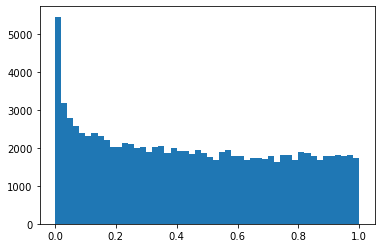

In [7]:
plt.hist(result.de_pval, bins=50)

### Compare donor resampling vs not

In [37]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
# adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()
# adata.obs['ind_cov'] = np.random.choice(['d'+str(i) for i in range(30)], size=adata.shape[0])

In [38]:
donors = adata.obs[['ind_cov']].drop_duplicates()
donors.index = np.arange(donors.shape[0])
for i in range(10):
    donors['tx_'+str(i)] = np.random.choice([-1, 1], donors.shape[0])

In [39]:
adata.obs['capture_rate'] = 0.1
# adata.obs['tx'] = np.random.choice([-1, 1], size=adata.shape[0])
# adata.obs = adata.obs.merge(donors, on='ind_cov', how='left')
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)

In [40]:
# adata.obs['tx'] = np.random.randint(2, size=adata.shape[0])

In [41]:
# Grouped by individual
adata1 = adata.copy().copy()
memento.create_groups(adata1, label_columns=['ind_cov'])
memento.compute_1d_moments(adata1, min_perc_group=.8)
treatment_df= pd.DataFrame(index=adata1.uns['memento']['groups'])

# treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(int)

treatment_df['ind_cov'] = treatment_df.index.str.split('^').str[1]
treatment_df = treatment_df.merge(donors, on='ind_cov').drop('ind_cov', axis=1)

In [48]:
memento.ht_1d_moments(
    adata1, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=1000, 
    verbose=1,
    num_cpus=93,
    resampling='bootstrap',
    approx=True,
    resample_rep=True)
memento_result1 = memento.get_1d_ht_result(adata1)

[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:   10.2s
[Parallel(n_jobs=93)]: Done 614 tasks      | elapsed:   15.9s
[Parallel(n_jobs=93)]: Done 1064 tasks      | elapsed:   23.4s
[Parallel(n_jobs=93)]: Done 1614 tasks      | elapsed:   32.5s
[Parallel(n_jobs=93)]: Done 1995 out of 1995 | elapsed:   40.2s finished


(array([2007., 2339., 2037., 1958., 1848., 1844., 1898., 1992., 2020.,
        2007.]),
 array([1.28853995e-05, 1.00001194e-01, 1.99989502e-01, 2.99977810e-01,
        3.99966119e-01, 4.99954427e-01, 5.99942735e-01, 6.99931043e-01,
        7.99919352e-01, 8.99907660e-01, 9.99895968e-01]),
 <BarContainer object of 10 artists>)

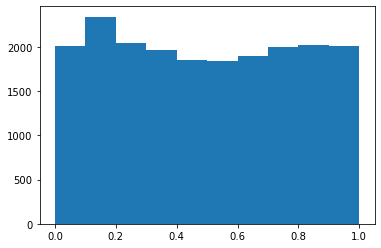

In [49]:
plt.hist(memento_result1.de_pval)

### Run memento for cbc eQTLs - debug whats going on

In [36]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()
# adata.obs['ind_cov'] = np.random.choice(['d'+str(i) for i in range(30)], size=adata.shape[0])

NameError: name 'pos' is not defined

In [ ]:
donors = adata.obs[['ind_cov']].drop_duplicates()
donors.index = np.arange(donors.shape[0])
# donors['tx'] = np.random.choice([-1, 1], donors.shape[0])

In [ ]:
adata.obs['capture_rate'] = 0.1
# adata.obs['tx'] = np.random.choice([-1, 1], size=adata2.shape[0])
adata.obs = adata.obs.merge(donors, on='ind_cov', how='left')
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)

In [ ]:
# adata.obs['tx'] = np.random.randint(2, size=adata.shape[0])

In [ ]:
# Grouped by individual
adata1 = adata.copy().copy()
memento.create_groups(adata1, label_columns=['ind_cov'])
memento.compute_1d_moments(adata1, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())
treatment_df= pd.DataFrame(index=adata1.uns['memento']['groups'])
treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)
memento.ht_1d_moments(
    adata1, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False,
    resample_rep=True)
memento_result1 = memento.get_1d_ht_result(adata1)


In [ ]:
# Grouped by individual
adata2 = adata.copy().copy()
memento.create_groups(adata2, label_columns=['tx'])
memento.compute_1d_moments(adata2, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())
treatment_df= pd.DataFrame(index=adata2.uns['memento']['groups'])
treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)
memento.ht_1d_moments(
    adata2, 
    covariate=pd.DataFrame(np.ones(2).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)
memento_result2 = memento.get_1d_ht_result(adata2)


In [ ]:
memento_result2.head(2)

In [ ]:
memento_result1.head(2)

In [ ]:
plt.hist(memento_result2['dv_pval'], bins=20)

In [ ]:
plt.hist(memento_result1['dv_pval'], bins=20)

In [ ]:
memento_result2.head(2)

In [ ]:
adata.shape

In [ ]:
# memento.compute_1d_moments(adata, min_perc_group=.5)

In [ ]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())

In [ ]:
covariates = pd.read_csv(data_path + 'cm_cg.mateqtl_cov.txt', sep='\t', index_col=0).T
cov_df = covariates[['age', 'Female'] + [x for x in covariates.columns if '_g' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
cov_df['donor'] = cov_df.index.values
cov_df = pd.get_dummies(cov_df)

In [ ]:
treatment_df = pd.DataFrame(index=adata.uns['memento']['groups'])

In [ ]:
# treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)

In [ ]:
treatment_df = pd.DataFrame(np.random.choice([-1, 1], size=(cov_df.shape[0], 2)))
# treatment_df = pd.DataFrame([[1], [0], [2]])


In [ ]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

In [ ]:
memento_result = memento.get_1d_ht_result(adata)


In [ ]:
memento_result.query('tx == 0').sort_values('de_coef').head(2)

In [ ]:
plt.hist(memento_result['de_pval'], bins=20)
plt.title('eQTL p-values with permutation 1')

In [ ]:
plt.hist(memento_result['de_pval'], bins=20)
plt.title('eQTL p-values with permutation 2')

In [ ]:
df = pd.DataFrame()
df['tx'] = treatment_df[0].values
df['mean'] = memento.get_1d_moments(adata)[1].query('gene == "S100P"').values[0][1:]

In [ ]:
stats.mannwhitneyu(df.query('tx==1')['mean'], df.query('tx==-1')['mean'])

In [ ]:
sns.boxplot(x='tx', y='mean', data=df)
sns.stripplot(x='tx', y='mean', data=df, linewidth=2)

In [ ]:
sns.kdeplot(memento_result.query('tx == 1')['de_coef'])
plt.plot([0, 0], [0, 18])

In [ ]:
sns.kdeplot(memento_result['de_coef'])
plt.plot([0, 0], [0, 18])

In [ ]:
plt.hist(memento_result['de_pval'], bins=10);

In [ ]:
memento_result

In [ ]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T

In [ ]:
donor_df['1:713977'].value_counts()

In [ ]:
donor_df['1:706368'].value_counts()

In [ ]:
donor_df.head(2)

In [ ]:
gene_to_snp = dict(cbc_eqtls[cbc_eqtls.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
# gene_to_snp = {'HP':['16:72135014']}

In [ ]:
np.random.randint(5, size=21000).max()

In [ ]:
# donor_df[donor_df.columns] = np.random.randint(3, size=donor_df.shape)

In [ ]:
donor_df = pd.DataFrame()
donor_df['tx'] = np.random.randint(2, size=cov_df.shape[0])

In [ ]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones(cov_df.shape[0]).reshape(-1, 1)),
    treatment=donor_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

In [ ]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


In [ ]:
sns.kdeplot(memento_result['de_coef'])

In [ ]:
memento_result

In [ ]:
plt.hist(memento_result['de_pval'])

In [ ]:
test = donor_df[['16:72165986']].copy()
test['mean'] = memento.get_1d_moments(adata)[0][['sg^' + x for x in test.index]].values.reshape(-1)

In [ ]:
cov_df.head(2)

In [ ]:
memento_result

In [ ]:
# memento_result.to_csv(data_path + 'cbc_eqtl_memento_cov_donor.csv', index=False)

### CBC eqtls

In [ ]:
memento_nocov = pd.read_csv(data_path + 'cbc_eqtl_memento.csv')
memento_cov = pd.read_csv(data_path + 'cbc_eqtl_memento_cov.csv')

In [ ]:
memento_result = memento_result.drop_duplicates(['de_coef'])

In [ ]:
memento_result['de_fdr'] = memento.util._fdrcorrect(memento_result['de_pval'])

In [ ]:
memento_result.query('de_fdr < 0.001').sort_values('de_coef')

In [ ]:
df = pd.DataFrame()
df['geno'] = donor_df['1:7981453'].values
df['mean'] = memento.get_1d_moments(adata)[1].query('gene == "UTS2"').values[0][1:]

In [ ]:
sns.boxplot(x='geno', y='mean', data=df)
sns.stripplot(x='geno', y='mean', data=df, linewidth=2)

In [ ]:
plt.hist(memento_result['dv_pval'])

In [ ]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


In [ ]:
merged = cbc_eqtls[['gene', 'rsid', 'beta', 'pvalue']].merge(memento_result[['gene', 'rsid', 'de_coef', 'de_pval']], on=['gene', 'rsid'])

In [ ]:
plt.scatter(-np.log(merged['pvalue']), -np.log(merged['de_pval']), s=1)
plt.ylabel('memento -log(p)'); plt.xlabel('mat eqtl -log(p)')
# plt.plot([0, 160], [0, 160], color='k')

In [ ]:
merged.shape

In [ ]:
plt.scatter(merged['beta'], merged['de_coef'], s=5)
plt.xlabel('mat eqtl coef'); plt.ylabel('memento coef')
plt.plot([-1, 4], [-1, 4], color='k')

### Get SNP-gene pairs using bedtools

In [ ]:
from pybedtools import BedTool

In [ ]:
snppos = pd.read_csv(data_path + 'cm_cg.snpspos.txt', sep='\t')
snppos['chrom'] = snppos['chr']
snppos['pos_start'] = snppos['pos']
snppos['pos_end'] = snppos['pos']
snppos['rsid'] = snppos['snps']
snppos = snppos[['chrom', 'pos_start', 'pos_end', 'rsid']]

In [ ]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [ ]:
tss_df = enc.get_tss_window(window_size=0)


In [ ]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')

In [ ]:
tss_df = tss_df[tss_df['symbol'].isin(adata.var.index)]

In [ ]:
tss_window_bed = BedTool.from_dataframe(tss_df)
snp_bed = BedTool.from_dataframe(snppos)

In [ ]:
result = BedTool.window(tss_window_bed, snp_bed, w=1000000).to_dataframe()

In [ ]:
gene_snp_pairs = result[['name', 'itemRgb']].drop_duplicates().rename(columns={'name':'gene', 'itemRgb':'rsid'})

In [ ]:
gene_snp_pairs.to_csv(data_path +'gene_snp_pairs.csv', index=False)


### Run memento on these gene-SNP pairs

In [ ]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()

In [ ]:
gene_snp_pairs = pd.read_csv(data_path +'gene_snp_pairs.csv')

In [ ]:
gene_snp_pairs.shape

In [ ]:
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)

In [ ]:
memento.create_groups(adata, label_columns=['ind_cov'])

In [ ]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

In [ ]:
gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))

In [ ]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T


In [ ]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones((donor_df.shape[0], 1))),
    treatment=donor_df,
    treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=93,
    resampling='bootstrap',
    approx=False)


In [ ]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


In [ ]:
memento_result.to_csv(data_path + 'cm_1M_result.csv')

In [ ]:
df = pd.DataFrame()
df['geno'] = donor_df['1:78723333'].values
df['mean'] = memento.get_1d_moments(adata)[0].query('gene == "IFI44L"').values[0][1:]

In [ ]:
sns.boxplot(x='geno', y='mean', data=df)
sns.stripplot(x='geno', y='mean', data=df, linewidth=2)

In [ ]:
plt.hist(memento_result['de_pval'])

In [ ]:
memento_result['fdr'] = memento.util._fdrcorrect(memento_result['de_pval'])

In [ ]:
memento_result['bonf'] = np.clip(memento_result['de_pval']*memento_result.shape[0], a_max=1, a_min=0)

In [ ]:
memento_result.query('fdr < 0.0007')

In [ ]:
plt.hist(memento_result['fdr'])

In [ ]:
memento_result.to_csv('cm_100k_result.csv', index=False)

In [ ]:
memento_result

In [ ]:
memento_result.query('bonf < 0.1')#.shape[0]

In [ ]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [ ]:
mapping = pd.read_csv('mart_export.txt', sep='\t')

In [ ]:
mapping['rsid'] = mapping['Chromosome/scaffold name'].astype(str) + ':'+mapping['Chromosome/scaffold position start (bp)'].astype(str)

In [ ]:
onek_replication = onek_replication.merge(mapping[['Variant name', 'rsid']], left_on='SNP_rsID', right_on='Variant name')

In [ ]:
onek_replication['gene'] = onek_replication['GeneID']

In [ ]:
gene_snp_pairs.query('gene == "LIPA"').query('rsid == "10:89243047"')

In [ ]:
onek_replication.merge(cbc_eqtls, on=['rsid', 'gene'])

In [ ]:
onek_replication['SNP_rsID'].drop_duplicates().shape

In [ ]:
memento_result['logp'] = -np.log(memento_result['de_pval'])

In [ ]:
cbc_eqtls['logp'] = -np.log(cbc_eqtls['pvalue'])

In [ ]:
plt.scatter(cbc_eqtls['beta'], cbc_eqtls['logp'], s=1)
plt.scatter(cbc_eqtls.merge(onek_replication, on=['rsid', 'gene'])['beta'], cbc_eqtls.merge(onek_replication, on=['rsid', 'gene'])['logp'], s=30)

In [ ]:
plt.scatter(memento_result['de_coef'], memento_result['logp'], s=1)
plt.scatter(memento_result.merge(onek_replication, on=['rsid', 'gene'])['de_coef'], memento_result.merge(onek_replication, on=['rsid', 'gene'])['logp'], s=30)

In [ ]:
pv_sorted = memento_result['de_pval'].sort_values().values

In [ ]:
quantiles = stats.uniform.ppf(np.linspace(0, 1, pv_sorted.shape[0]), loc=0, scale=1)

In [ ]:
memento_result.sort_values('de_pval').head(15)

### 1K1K replication

In [ ]:
onek1k_pos = pd.read_csv('1k1k_snps_chrpos.txt', header=None).iloc[:,0].tolist()
onek1k_info = pd.read_csv('1k1k_snp_info.txt', sep='\t', header=None).iloc[:,:3]
onek1k_info.columns = ['chr', 'pos', 'name']
onek1k_info['rsid'] = onek1k_info['chr'].astype(str) + ':' + onek1k_info['pos'].astype(str)

In [ ]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [ ]:
onek_replication = onek_replication.merge(onek1k_info, left_on='SNP_rsID', right_on='name').query('cell_type == "Mono_C"')

In [ ]:
cbc_eqtls.head(2)

In [ ]:
cbc_overlap = onek_replication

In [ ]:
onek_replication['gene'] = onek_replication['GeneID']

In [ ]:
onek_replication.head(2)

In [ ]:
cbc_eqtls.shape

In [ ]:
onek_replication.merge(cbc_eqtls, on=['gene', 'rsid']).shape

In [ ]:
memento_result.shape

In [ ]:
memento_result = pd.read_csv('cm_100k_result.csv').sort_values('de_coef')#.head(98063)

In [ ]:
onek_replication.merge(memento_result, on=['gene', 'rsid']).shape

In [ ]:
onek_replication.head(2)

In [ ]:
overlap = set(onek1k_info['rsid']) & set(pos.index.tolist())

In [ ]:
len(overlap)

In [ ]:
hits_snps = set(onek_replication.rsid.tolist())

In [ ]:
set(overlap) & set(hits_snps)

In [ ]:
onek_replication.query('rsid in @overlap')

### Test

In [ ]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()

In [ ]:
gene_snp_pairs = pd.read_csv(data_path +'gene_snp_pairs.csv')
gene_snp_pairs = gene_snp_pairs.query('gene == "IFITM3" & rsid == "11:388579"')

In [ ]:
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)

In [ ]:
memento.create_groups(adata, label_columns=['ind_cov'])

In [ ]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=['IFITM3'])

In [ ]:
gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))

In [ ]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T


In [ ]:
boot_mean = memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones((donor_df.shape[0], 1))),
    treatment=donor_df,
    treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=1,
    resampling='bootstrap',
    approx=True)


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
coefs = LinearRegression().fit(donor_df[['11:388579']].values, boot_mean).coef_.reshape(-1)

In [ ]:
coefs.shape

In [ ]:
np.nanstd(coefs)

In [ ]:
sns.kdeplot(coefs)

In [ ]:
boot_mean

In [ ]:
memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})

In [ ]:
-np.log(pv_sorted)

In [ ]:
plt.scatter(-np.log(quantiles), -np.log(pv_sorted))

In [ ]:
quantiles

In [ ]:
pv_

In [ ]:
memento_result['de_pval']

### P-value histogram

In [ ]:
import pandas as pd

In [ ]:
result = pd.read_csv(data_path + 'window_100k/100k_result.csv', index_col=0)

In [ ]:
mateqtl_result = pd.r

In [ ]:
theoretical = -np.log10(np.linspace(1e-9, 1, result.shape[0]))
actual = -np.log10(result['de_pval'].sort_values().values)

In [ ]:
plt.scatter(theoretical, actual, s=1)
plt.plot(theoretical, theoretical, color='r')

In [ ]:
mateqtl_output = pd.read_csv(data_path + 'mateqtl_output/cm_cg_mateqtl_cis_cov.out', sep='\t')
mateqtl_output['hit_id'] = mateqtl_output['gene'] + '*' + mateqtl_output['SNP']
# mateqtl_output['onek_valid'] = mateqtl_output['hit_id'].isin(onek_replication['hit_id'])
mateqtl_output['pvalue'] = mateqtl_output['p-value']

In [ ]:
theoretical_meq = -np.log10(np.linspace(1e-9, 1, mateqtl_output.shape[0]))
actual_meq = -np.log10(mateqtl_output['p-value'].sort_values().values)

In [ ]:
plt.scatter(theoretical, actual, s=1)
plt.scatter(theoretical_meq, actual_meq, s=1)
plt.plot(theoretical, theoretical, color='r')

